In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 15.6 MB/s eta 0:00:00


In [2]:
from nltk.corpus import stopwords
from datasets import load_dataset
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from gensim.models.word2vec import Word2Vec
from sklearn.decomposition import PCA
from sklearn import decomposition
import numpy as np
import pyarrow
import spacy
import nltk
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import random
def seed_everything(seed=73):
    random.seed(seed)
    np.random.seed(seed)

seed_everything(1234)

In [4]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [5]:
dataset  = load_dataset("go_emotions", "simplified")

train = dataset['train'].to_pandas()
validation = dataset['validation'].to_pandas()
test = dataset['test'].to_pandas()

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
initial_emotion_dict = {0: 'admiration',
1: 'amusement',
2: 'anger',
3: 'annoyance',
4: 'approval',
5: 'caring',
6: 'confusion',
7: 'curiosity',
8: 'desire',
9: 'disappointment',
10: 'disapproval',
11: 'disgust',
12: 'embarrassment',
13: 'excitement',
14: 'fear',
15: 'gratitude',
16: 'grief',
17: 'joy',
18: 'love',
19: 'nervousness',
20: 'optimism',
21: 'pride',
22: 'realization',
23: 'relief',
24: 'remorse',
25: 'sadness',
26: 'surprise',
27: 'neutral'}

n_labels = len(initial_emotion_dict)+1

In [7]:
subsets = train.labels.value_counts().index[0:14]
print(subsets) #returns most frequent 13 indexes + other_emotions for the rest.
kept_labels = [index[0] for index in subsets]
print(kept_labels)
kept_labels = np.array(kept_labels)

Index([[27], [0], [4], [15], [1], [3], [18], [10], [7], [2], [20], [6], [17],
       [25]],
      dtype='object')
[27, 0, 4, 15, 1, 3, 18, 10, 7, 2, 20, 6, 17, 25]


In [8]:
N_CLASSES = len(kept_labels)+1  #for other_emotions

not_kept_labels = np.arange(0,28)
not_kept_labels = np.delete(not_kept_labels, kept_labels)

def one_hot_encoder(df):
    one_hot_encoding = []
    for i in tqdm(range(len(df))):
        temp = [0]*n_labels
        label_indices = df.iloc[i]["labels"]
        for index in label_indices:
            if index in kept_labels:
              temp[index] = 1
            else:
              temp[n_labels-1] = 1 #other_emotions become 1
        temp = np.delete(temp,not_kept_labels)
        one_hot_encoding.append(temp)
    return pd.DataFrame(one_hot_encoding)

In [9]:
train_labels = one_hot_encoder(train)
valid_labels = one_hot_encoder(validation)
test_labels = one_hot_encoder(test)




  0%|          | 0/43410 [00:00<?, ?it/s]


  3%|▎         | 1116/43410 [00:00<00:03, 11154.82it/s]


  5%|▌         | 2240/43410 [00:00<00:03, 11199.32it/s]


  8%|▊         | 3360/43410 [00:00<00:03, 10399.63it/s]


 10%|█         | 4481/43410 [00:00<00:03, 10703.41it/s]


 13%|█▎        | 5563/43410 [00:00<00:03, 10741.88it/s]


 15%|█▌        | 6647/43410 [00:00<00:03, 10772.47it/s]


 18%|█▊        | 7727/43410 [00:00<00:03, 10558.69it/s]


 21%|██        | 8911/43410 [00:00<00:03, 10955.14it/s]


 23%|██▎       | 10041/43410 [00:00<00:03, 11058.10it/s]


 26%|██▌       | 11195/43410 [00:01<00:02, 11204.14it/s]


 29%|██▊       | 12454/43410 [00:01<00:02, 11623.68it/s]


 31%|███▏      | 13618/43410 [00:01<00:02, 11484.44it/s]


 34%|███▍      | 14768/43410 [00:01<00:02, 11027.87it/s]


 37%|███▋      | 15876/43410 [00:01<00:02, 10949.56it/s]


 39%|███▉      | 16974/43410 [00:01<00:02, 10883.16it/s]


 42%|████▏     | 18065/43410 [00:01<00:02, 10792.10it/s]


 44%|████▍     | 

In [10]:
train = pd.concat([train, train_labels], axis=1)
valid = pd.concat([validation, valid_labels], axis=1)
test = pd.concat([test, test_labels], axis=1)

In [11]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,My favourite food is anything I didn't have to...,[27],eebbqej,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [12]:
emotion_dict = dict()
for index,value in enumerate(np.sort(kept_labels)):
    emotion_dict[index] = initial_emotion_dict[value]
emotion_dict[len(kept_labels)] = 'other_emotions'
emotion_dict

{0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'confusion',
 6: 'curiosity',
 7: 'disapproval',
 8: 'gratitude',
 9: 'joy',
 10: 'love',
 11: 'optimism',
 12: 'sadness',
 13: 'neutral',
 14: 'other_emotions'}

In [13]:
tokenizer = RegexpTokenizer(r"[\w']+")
en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [14]:
import re

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(words):
    word_list = []
    for word in words:
        if word not in en_stop:
            word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
            word_list.append(word)
    return word_list

#sentences first are tokenized and return a list for each and the lists will be lemmatized and returns a list of lemmatized words by using above pre_process function. 
def tokenize(df_text):
    token_list = []
    for sentences in df_text:
        sentences = re.sub('[^A-Za-z0-9 ]+', '', sentences)
        token_list.append(lemmatize(tokenizer.tokenize(sentences.lower())))
    return token_list
        
#####OPTION 2####
# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     doc = nlp(texts) 
#     texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

# for i, splits in enumerate(sentence_list):
#     print(i)
#     for sentences in splits:
#         sentences = sentences.as_py()
#         token_list[i] = token_list[i] + [lemmatization(sentences)[0]]

####OPTION 3#####
# for i, splits in enumerate(sentence_list):
#     print(i)
#     for sentences in splits:
#         sentences = sentences.as_py()
#         token_list[i] = token_list[i] + [gensim.utils.simple_preprocess(sentences)]

In [15]:
train_text = tokenize(train.text)
valid_text = tokenize(valid.text)
test_text = tokenize(test.text)

In [16]:
num_features = 400
min_word_count = 1
num_workers = 2
window_size = 5
subsampling = 1e-3
setting = 1 #skip-gram setting

w2v_model = Word2Vec(train_text, sg=setting, workers=num_workers, vector_size=num_features, min_count=min_word_count, window=window_size, sample=subsampling)

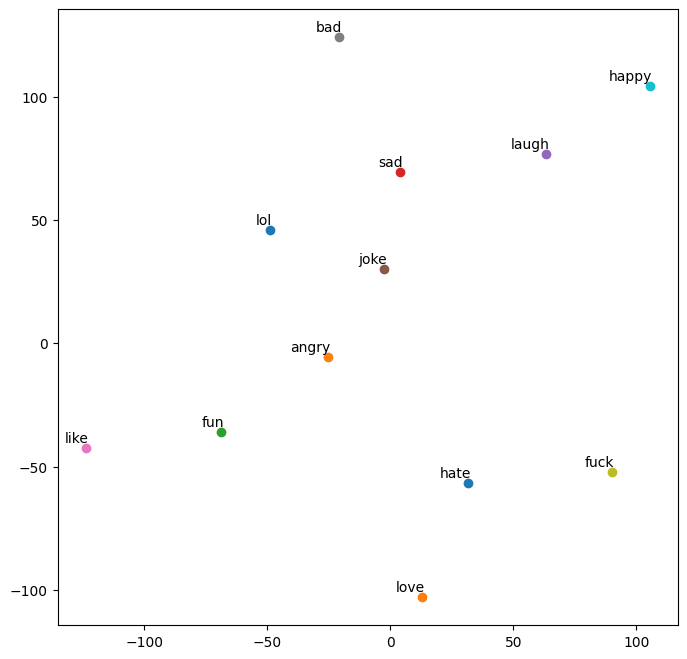

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vocab = ["hate", "love", "fun", "sad", "laugh", "joke", "like", "bad", "fuck", "happy", "lol", "angry"]

def tsne_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    coordinates = tsne_model.fit_transform(np.array(wordvecs))

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8,8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(w2v_model)

In [18]:
w2v_model.wv.most_similar("hate")

[('actual', 0.9529831409454346),
 ('call', 0.9466569423675537),
 ('hat', 0.9465290904045105),
 ('reason', 0.9450919032096863),
 ('shame', 0.9378678202629089),
 ('stupid', 0.9347884058952332),
 ('agree', 0.9326760172843933),
 ('supporter', 0.9278762340545654),
 ('absolutely', 0.9270060062408447),
 ('america', 0.9254119396209717)]

In [19]:
w2v_model.wv.most_similar("funny")

[('exactly', 0.9806994199752808),
 ('true', 0.9765360951423645),
 ('dumb', 0.9741568565368652),
 ('hilarious', 0.9739652276039124),
 ('sad', 0.9729871153831482),
 ('meant', 0.966873049736023),
 ('totally', 0.9657915830612183),
 ('kinda', 0.9657909274101257),
 ('weird', 0.9645773768424988),
 ('disgust', 0.9645202159881592)]

In [20]:
import gensim.corpora as corpora

texts = train_text

id2word = corpora.Dictionary(train_text)

corpus = [id2word.doc2bow(text) for text in texts]

In [21]:
import gensim
num_topics = 28
#TODO: Use the LdaMulticore function to build an LDA model with the finalized hyperparameters
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [22]:
!mkdir results
!pip install pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 42.1 MB/s eta 0:00:00


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.206342  0.010272       1        1  10.089899
26    -0.009011  0.175211       2        1   7.991194
16    -0.081625 -0.032413       3        1   7.529877
0     -0.008612 -0.107761       4        1   6.960902
23     0.026657  0.062065       5        1   5.953363
13     0.022521 -0.009862       6        1   5.125125
12     0.023070 -0.006264       7        1   4.490963
8      0.011655 -0.013024       8        1   4.378652
15     0.022478 -0.007462       9        1   4.130524
22     0.019051 -0.007361      10        1   4.124684
2      0.016113 -0.006127      11        1   3.487982
14     0.010555 -0.006736      12        1   3.318540
3      0.014197 -0.003036      13        1   3.190757
24    -0.003529 -0.005299      14        1   2.891520
10     0.014018 -0.005407      15        1   2.883232
25     0.014059 -0.006048      16        1   2.835004
7      0.012644 -0.001654      17        1   2.400824
11     0.014424 -0.006479      18        1   2.283682
4      0.013707 -0.003981      19        1   2.200033
21     0.010246 -0.002024      20        1   2.170592
20     0.009780 -0.002528      21        1   2.000399
5      0.009075 -0.003668      22        1   1.928672
9      0.010962 -0.003138      23        1   1.869032
18     0.011833 -0.003847      24        1   1.622351
17     0.007362 -0.001288      25        1   1.367467
19     0.007576 -0.000755      26        1   1.185470
6      0.004583 -0.001010      27        1   0.882644
27     0.002556 -0.000375      28        1   0.706616, topic_info=             Term         Freq        Total Category  logprob  loglift
50           name  4251.000000  4251.000000  Default  30.0000  30.0000
135           get  1951.000000  1951.000000  Default  29.0000  29.0000
77             im  1726.000000  1726.000000  Default  28.0000  28.0000
70           dont  1555.000000  1555.000000  Default  27.0000  27.0000
115          like  1610.000000  1610.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
967    masturbate     0.660638    12.717382  Topic28  -8.0690   1.9949
21966   hourglass     0.460809     9.381318  Topic28  -8.4293   1.9389
2943      tkachuk     0.543942    12.057182  Topic28  -8.2634   1.8539
7006          mid     0.838988    28.483930  Topic28  -7.8300   1.4275
2602         west     0.642313    23.226653  Topic28  -8.0972   1.3645

[947 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
751       1  0.012133      1
751       2  0.012133      1
751       3  0.012133      1
751       4  0.012133      1
751      10  0.897866      1
...     ...       ...    ...
392      15  0.973817  youre
744       1  0.016036  youve
744       2  0.016036  youve
744       3  0.016036  youve
744      18  0.849890  youve

[4623 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 27, 17, 1, 24, 14, 13, 9, 16, 23, 3, 15, 4, 25, 11, 26, 8, 12, 5, 22, 21, 6, 10, 19, 18, 20, 7, 28])

In [23]:
pca = decomposition.PCA(n_components=1)

def pca_transform(X_):
    X_pca = []
    for v in X_:
        if v.size:
            X_pca.append(pca.fit_transform(v.T)) #X_vects shapes were (word_count,300), by the PCA turn into (300,1)
        else:
            X_pca.append(np.zeros((num_features,1)))
            
    x,y,z = np.array(X_pca).shape
    return np.array(X_pca).reshape(x,y)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
words = set(w2v_model.wv.index_to_key)
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in train_text])
X_validation_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in valid_text])

X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in test_text])
        
X_train_vect_pca = pca_transform(X_train_vect)
X_validation_vect_pca = pca_transform(X_validation_vect)
X_test_vect_pca = pca_transform(X_test_vect)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
%%time
!pip install scikit-multilearn
from skmultilearn.problem_transform import LabelPowerset as tf
from sklearn.linear_model import LogisticRegression as ml

classifier = tf(ml(max_iter=1000))

classifier.fit(X_train_vect_pca,np.array(train[range(N_CLASSES)].values.tolist()))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 4.9 MB/s eta 0:00:00
CPU times: user 27min 13s, sys: 5min 49s, total: 33min 3s
Wall time: 21min 36s


LabelPowerset(classifier=LogisticRegression(max_iter=1000),
              require_dense=[True, True])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


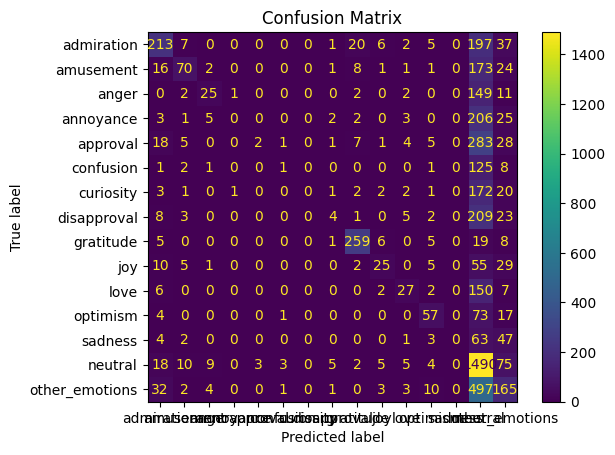

                precision    recall  f1-score   support

    admiration       0.62      0.44      0.51       488
     amusement       0.65      0.24      0.35       303
         anger       0.55      0.13      0.21       195
     annoyance       0.00      0.00      0.00       303
      approval       0.40      0.01      0.01       397
     confusion       0.14      0.01      0.01       152
     curiosity       0.00      0.00      0.00       248
   disapproval       0.29      0.02      0.03       292
     gratitude       0.98      0.85      0.91       358
           joy       0.55      0.16      0.25       172
          love       0.54      0.12      0.20       252
      optimism       0.70      0.34      0.46       209
       sadness       0.00      0.00      0.00       143
       neutral       0.42      0.92      0.57      1766
other_emotions       0.42      0.22      0.29      1036

     micro avg       0.48      0.41      0.44      6314
     macro avg       0.42      0.23      0.25 

In [26]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, auc, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compute_metrics(labels,preds):
    
    assert len(preds) == len(labels)
    results = dict()

    fpr_micro, tpr_micro, _ = roc_curve(labels.ravel(), preds.values.ravel())
    results["auc_micro"] = auc(fpr_micro, tpr_micro)

    cm = confusion_matrix(np.array(labels).argmax(axis=1),np.array(preds).argmax(axis=1)) #confusion matrix of adjusted threshold
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_dict.values())
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

    labels = labels.tolist()
    print(classification_report(labels,preds,target_names=emotion_dict.values()))

    results["accuracy"] = accuracy_score(labels, preds)

    results["macro_precision"], results["macro_recall"], results[
        "macro_f1"], _ = precision_recall_fscore_support(
        labels, preds, average="macro")

    results["micro_precision"], results["micro_recall"], results[
        "micro_f1"], _ = precision_recall_fscore_support(
        labels, preds, average="micro")

    results["weighted_precision"], results["weighted_recall"], results[
        "weighted_f1"], _ = precision_recall_fscore_support(
        labels, preds, average="weighted")

    return results
  
y_pred = classifier.predict(X_validation_vect_pca)
valid_pred = pd.DataFrame.sparse.from_spmatrix(y_pred)

valid_result = compute_metrics(valid[range(N_CLASSES)].values,valid_pred)

print("validation metric results:", valid_result)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


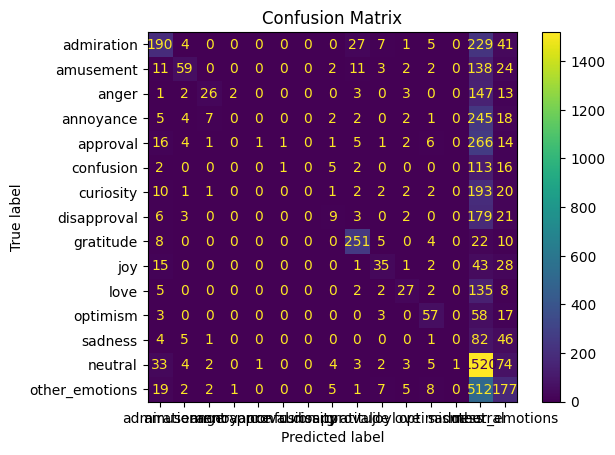

                precision    recall  f1-score   support

    admiration       0.58      0.38      0.46       504
     amusement       0.70      0.23      0.35       264
         anger       0.65      0.13      0.22       198
     annoyance       0.00      0.00      0.00       320
      approval       0.50      0.00      0.01       351
     confusion       0.50      0.01      0.01       153
     curiosity       0.00      0.00      0.00       284
   disapproval       0.41      0.04      0.08       267
     gratitude       0.95      0.84      0.89       352
           joy       0.58      0.24      0.34       161
          love       0.67      0.15      0.25       238
      optimism       0.68      0.35      0.46       186
       sadness       0.00      0.00      0.00       156
       neutral       0.42      0.92      0.58      1787
other_emotions       0.46      0.23      0.31      1055

     micro avg       0.48      0.42      0.45      6276
     macro avg       0.47      0.24      0.26 

In [27]:
y_pred = classifier.predict(X_test_vect_pca)
test_pred = pd.DataFrame.sparse.from_spmatrix(y_pred)

test_result = compute_metrics(test[range(N_CLASSES)].values,test_pred)

print("test metric results:", test_result)

In [28]:
def predict_sentiment(model, sentence):
      def sentence_tokenize(sentence):
        token_list = []
        sentences = re.sub('[^A-Za-z0-9 ]+', '', sentence)
        token_list.append(lemmatize(tokenizer.tokenize(sentences.lower())))
        return token_list[0]

      tokenized = sentence_tokenize(sentence)
      print(tokenized)
      sentence_vect = np.array([w2v_model.wv[i] for i in tokenized if i in words])

      def sentence_pca(sentence_vect):
          pcad_ = []
          if sentence_vect.size:
              pcad_.append(pca.fit_transform(sentence_vect.T)) #X_vects shapes were (word_count,300), by the PCA turn into (300,1)
          else:
              pcad_.append(np.zeros((num_features,1)))
        
          x,y,z = np.array(pcad_).shape
          return np.array(pcad_).reshape(x,y)
    
      pcad = sentence_pca(sentence_vect)
      y_pred = classifier.predict(pcad)
      pred = pd.DataFrame.sparse.from_spmatrix(y_pred)

      return pred

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
predict_sentiment(classifier, "Troll, bro. They know they're saying stupid shit. The motherfucker does nothing but stink up libertarian subs talking shit")

['troll', 'bro', 'know', 'theyre', 'say', 'stupid', 'shit', 'motherfucker', 'nothing', 'stink', 'libertarian', 'sub', 'talk', 'shit']


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
